# GluonTS <span style="color:orange"> Tutorial</span> 

---
> ## Table of contents
> 1. ### <span style="color:orange">Datasets</span>
    1.1 Available datasets on GluonTS     
    1.2 Create artificial datasets with GluonTS  
    1.3 Use your time series and features
> 2. ### <span style="color:orange">Transformation</span>
    2.1 Define a transformation  
    2.2 Transform a dataset 
> 3. ### <span style="color:orange">Training an existing model</span>
> 4. ### <span style="color:orange">Evaluation</span>
> 5. ### <span style="color:orange">Create your own model</span>
    5.1 Point forecasts with a simple feedforward network  
    5.2 Probabilistic forecasting  
    5.3 Add features and scaling   
    
---

In [1]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

In [2]:
mx.random.seed(0)
np.random.seed(0)

# 1. Datasets

The first requirement to use GluonTS is to have an appropriate dataset. GluonTS offers three different options to practitioners that want to experiment with the various modules: 
- Use an available dataset provided by GluonTS
- Create an artificial dataset using GluonTS
- Convert your dataset to a GluonTS friendly format

In general, a dataset should satisfy some minimum format requirements to be compatible with GluonTS. In particular, it should be an iterable collection of data entries (time series), and each entry should have at least a `target` field, which contains the actual values of the time series, and a `start` field, which denotes the starting date of the time series. There are many more optional fields that we will go throught in this tutorial.

The datasets provided by GluonTS come in the appropriate format and they can be used without any post processing. However, a custom dataset needs to be converted. Fortunately this is an easy task.

## 1.1 Available datasets on GluonTS

GluonTS comes with a number of available datasets. 

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'exchange_rate', 'electricity', 'traffic', 'solar-energy']


An available dataset can be easily downloaded by its name. If the dataset already exists locally it is not downloaded again by setting `regenerate=False`.

In [5]:
dataset = get_dataset("m4_hourly", regenerate=False)

INFO:root:using dataset already processed in path m4_hourly.


#### What is in a dataset?

In general, the datasets provided by GluonTS are objects that consists of three main components:
- `dataset.train` is an iterable collection of data entries used for training.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length of the particular dataset.
- `dataset.metadata` containts metadata of the dataset such as the frequency of the time series, the recommended prediction length, associated features, etc. 

First, let's see what the first entry of the train dataset contains. We should expect at least a `target` anf a `start` field in each entry, and the target of the test entry to have an additional window equal to `prediction_length`.

In [6]:
train_entry = next(iter(dataset.train))
train_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'source'])

We observe that apart from the required fields there is one more `feat_static_cat` field (we can safely ignore the `source` field). This shows that the dataset has some features apart from the values of the time series. For now, we will ignore this field too. We will explain it in detail later with all the other optional fields.

We can similarly examine the first entry of the test dataset. We should expect exactly the same fields as in the train dataset.    

In [7]:
test_entry = next(iter(dataset.test))
test_entry.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'source'])

Moreover, we should expect that the target will have an additional window in the end with length equal to `prediction_length`. To better understand what this means we can visualize both the train and test time series. 

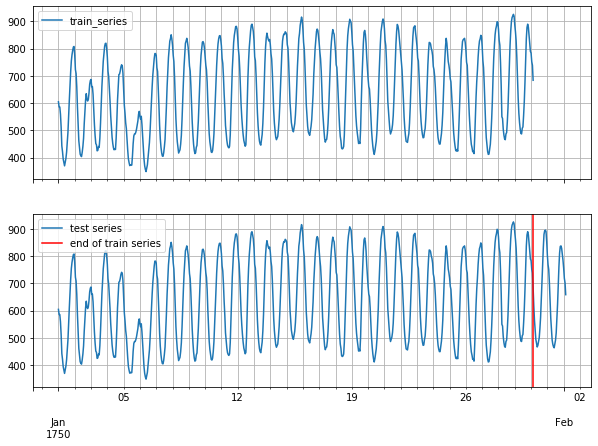

In [8]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train_series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [9]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.time_granularity}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## 1.2 Create artificial datasets

We can easily create a complex artificial time series dataset using the `ComplexSeasonalTimeSearies` module.

In [10]:
from gluonts.dataset.artificial._base import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset

In [11]:
artificial_dataset = ComplexSeasonalTimeSeries(
    num_series=10,
    prediction_length=21,
    freq_str="H",
    length_low=30,
    length_high=200,
    min_val=-10000,
    max_val=10000,
    is_integer=False,
    proportion_missing_values=0,
    is_noise=True,
    is_scale=True,
    percentage_unique_timestamps=1,
    is_out_of_bounds_date=True,
)

We can access some important metadata of the artificial dataset as follows:

In [12]:
print(f"prediction length: {artificial_dataset.metadata.prediction_length}")
print(f"frequency: {artificial_dataset.metadata.time_granularity}")

prediction length: 21
frequency: H


The artificial dataset that we created is a list of dictionaries. Each dictionary corresponds to a time series and it should contain the required fields.

In [13]:
print(f"type of train dataset: {type(artificial_dataset.train)}")
print(f"train dataset fields: {artificial_dataset.train[0].keys()}")
print(f"type of test dataset: {type(artificial_dataset.test)}")
print(f"test dataset fields: {artificial_dataset.test[0].keys()}")

type of train dataset: <class 'list'>
train dataset fields: dict_keys(['start', 'target', 'item'])
type of test dataset: <class 'list'>
test dataset fields: dict_keys(['start', 'target', 'item'])


In order to use the artificially created datasets (list of dictionaries) we need to convert them to `ListDataset` objects.

In [14]:
train_ds = ListDataset(artificial_dataset.train, 
                        freq=artificial_dataset.metadata.time_granularity)

In [15]:
test_ds = ListDataset(artificial_dataset.test, 
                       freq=artificial_dataset.metadata.time_granularity)

In [16]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['start', 'target', 'item', 'source'])

In [17]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['start', 'target', 'item', 'source'])

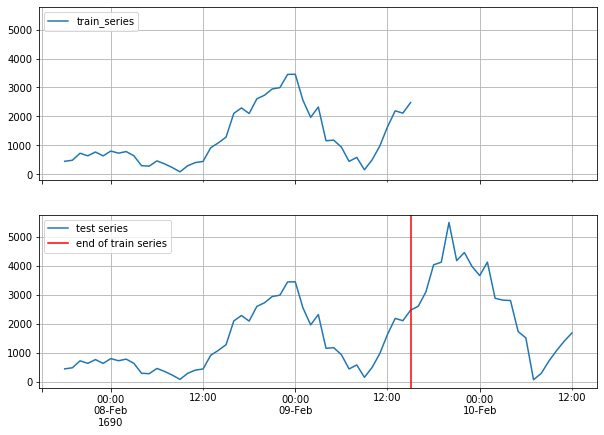

In [18]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train_series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## 1.3 Use your time series and features

Now, we will see how we can convert any custom dataset with any associated features to an appropriate format for GluonTS.

As already mentioned a dataset is required to have at least the `target` and the `start` fields. However, it may have more. Let's see what are all the available fields: 

In [19]:
from gluonts.transform import FieldName

In [20]:
[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'"]

The fields are split into three categories: the required ones, the optional ones, and the ones that can be added by the `Transformation` (explained in a while).

Required:
- `start`: start date of the time series
- `target`: values of the time series

Optional:
- `feat_static_cat`: static (over time) categorical features, list with dimension equal to the number of features
- `feat_static_real`: static (over time) real features, list with dimension equal to the number of features
- `feat_dynamic_cat`: dynamic (over time) categorical features, array with shape equal to (target length, number of features)
- `feat_dynamic_real`: dynamic (over time) real features, array with shape equal to (target length, number of features)

Added by `Transformation`:
- `time_feat`: time related features such as the month or the day 
- `feat_dynamic_const`: expands a constant value feature along the time axis
- `feat_dynamic_age`: age feature, i.e., a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp
- `observed_values`: indicator for observed values, i.e., a feature thatequals to 1 if the value is observed and 0 if the value is missing
- `is_pad`: indicator for each time step that shows if it is padded (if the length is not enough) 
- `forecast_start`: forecast start date

As a simple example, we can create a custom dataset to see how we can use some of these fields. The dataset consists of a target, a real dynamic feature (which in this example we set to be the target value one period earlier), and a static categorical feature that indicates the sinusoid type (different phase) that we used to create the target.  

In [21]:
def create_dataset(num_series, num_steps, prediction_length, period=24, mu=1, sigma=0.3):
    # create target: noise + pattern    
    # noise
    noise = np.random.normal(mu, sigma, size=(num_series, num_steps))
    
    # pattern - sinusoid with different phase
    sin_minumPi_Pi = np.sin(np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period)))
    sin_Zero_2Pi = np.sin(np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period)))
    
    pattern = np.concatenate((np.tile(sin_minumPi_Pi.reshape(1, -1), 
                                      (int(np.ceil(num_series / 2)),1)), 
                              np.tile(sin_Zero_2Pi.reshape(1, -1), 
                                      (int(np.floor(num_series / 2)), 1))
                             ),
                             axis=0
                            )
    
    target = noise + pattern
    
    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.concatenate((np.zeros((num_series, period)), 
                                        target[:, :-period]
                                       ), 
                                       axis=1
                                      )
    
    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.concatenate((np.zeros(int(np.ceil(num_series / 2))), 
                                      np.ones(int(np.floor(num_series / 2)))
                                     ),
                                     axis=0
                                    )
    
    return target, feat_dynamic_real, feat_static_cat
    

In [22]:
# define the parameters of the dataset
custom_ds_metadata = {'num_series': 100,
                      'num_steps': 24 * 7,
                      'prediction_length': 24,
                      'freq': '1H',
                      'start': [pd.Timestamp("01-01-2019", freq='1H') 
                                for _ in range(100)]
                     }

In [23]:
data_out = create_dataset(custom_ds_metadata['num_series'], 
                          custom_ds_metadata['num_steps'],                                                      
                          custom_ds_metadata['prediction_length']
                         )

target, feat_dynamic_real, feat_static_cat = data_out

We can easily create the train and test datasets by simply filling in the correct fields. Remember that for the train dataset we need to cut the last window.

In [24]:
train_ds = ListDataset([{FieldName.TARGET: target, 
                         FieldName.START: start,
                         FieldName.FEAT_DYNAMIC_REAL: fdr,
                         FieldName.FEAT_STATIC_CAT: fsc} 
                        for (target, start, fdr, fsc) in zip(target[:, :-custom_ds_metadata['prediction_length']], 
                                                             custom_ds_metadata['start'], 
                                                             feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']], 
                                                             feat_static_cat)],
                      freq=custom_ds_metadata['freq'])

In [25]:
test_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start,
                        FieldName.FEAT_DYNAMIC_REAL: fdr,
                        FieldName.FEAT_STATIC_CAT: fsc} 
                       for (target, start, fdr, fsc) in zip(target, 
                                                            custom_ds_metadata['start'], 
                                                            feat_dynamic_real, 
                                                            feat_static_cat)],
                     freq=custom_ds_metadata['freq'])

Now, we can examine each entry of the train and test datasets. We should expect that they have the following fields: `target`, `start`, `feat_dynamic_real` and `feat_static_cat`.

In [26]:
train_entry = next(iter(train_ds))
train_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

In [27]:
test_entry = next(iter(test_ds))
test_entry.keys()

dict_keys(['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source'])

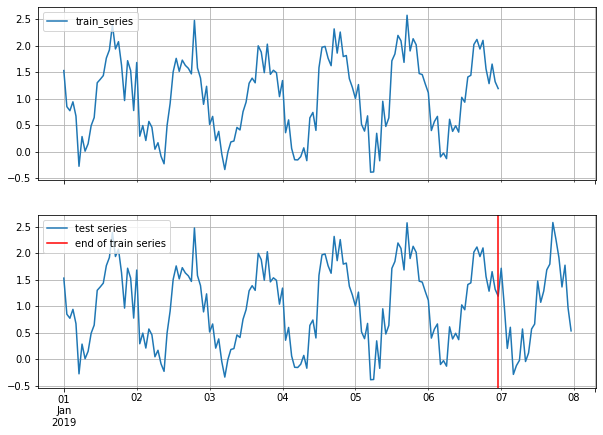

In [28]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train_series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

<span style="color:red">*For the rest of the tutorial we will use the custom dataset*</span>

# 2. Transformation

## 2.1 Define a transformation

The job of a `Transformation` is to get an iterable collection of entries of a dataset and transform it to another iterable collection that contains possibly more fields useful for our forecasting application.

The transformation is done by defining a set of "actions" to the raw dataset depending on what is usefiul to our model. This actions usually create some additional features or transform an existing feature. As an example, in the following we add the following transformations:
- `AddObservedValuesIndicator`: Creates the `observed_values` field in the dataset, i.e., adds a feature that equals to 1 if the value is observed and 0 if the value is missing 
- `AddAgeFeature`: Creates the `feat_dynamic_age` field in the dataset, i.e., adds a feature that its value is small for distant past timestamps and it monotonically increases the more we approach the current timestamp   

The `Transformation` may not define an additional field in the dataset. However, it **always** needs to define how the datasets are going to be split in example windows during training and testing. This is done with the `InstanceSplitter` that is configured as follows (skipping the obvious fields):
- `is_pad_field`: indicator if the time series is padded (if the length is not enough)
- `train_sampler`: defines how the training windows are cut/sampled
- `time_series_fields`: contains the time dependent features that need to be split in the same manner as the target

In [29]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    FieldName,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [30]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

## 2.2 Transform a dataset

Now, we can create a transformation object by applying the above transformation to the custom dataset we have created.

In [31]:
transformation = create_transformation(custom_ds_metadata['freq'], 
                                       2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
                                       custom_ds_metadata['prediction_length'])

In [32]:
train_tf = transformation(iter(train_ds), is_train=True)

In [33]:
type(train_tf)

generator

As expected, the output is another iterable object. We can easily examine what is contained in an entry of the transformed dataset. When `is_train=True` in the transformation, the `InstanceSplitter` iterates over the transformed dataset and cuts windows by selecting randomly a time series and a starting point on that time series (this "randomness" is defined by the `train_sampler`). 


In [34]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

The transformer has done what we asked. In particular it has added:
- a field for observed values (`observed_values`)  
- a field for the age feature (`feat_dynamic_age`)
- some extra useful fields (`past_is_pad`, `forecast_start`)

It has done one more important thing: it has splitted the window in past and future and has added the corresponding prefixes to all time dependent fields. This way we can easily use e.g., the `past_target` field as input and the `future_target` field to calculate the error of our predictions. Of course, the length of the past is equal to the `context_length` and of the future equal to the `prediction_length`.

In [35]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
print(train_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (24,)
past observed values shape: (48,)
future observed values shape: (24,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


Just for comparison, let's see again what were the fields in the original dataset before the transformation:

In [36]:
[k for k in next(iter(train_ds)).keys()]

['target', 'start', 'feat_dynamic_real', 'feat_static_cat', 'source']

Now, we can move on and see how the test dataset is split. As we saw, the transformation splits the windows to past and future. However, during inference (`is_train=False` in the transformation), the splitter always cuts the last window (of length `context_length`) of the dataset so it can be used to predict the subsequent unknown values of length `prediction_length`. 

So, how is the test dataset split in past and futere since we do not know the future target? And what about the time dependent features?

In [37]:
test_tf = transformation(iter(test_ds), is_train=False)

In [38]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'feat_static_cat',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [39]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
print(test_tf_entry['feat_static_cat'])

past target shape: (48,)
future target shape: (0,)
past observed values shape: (48,)
future observed values shape: (0,)
past age feature shape: (48, 1)
future age feature shape: (24, 1)
[0]


The future target is empty but not the features - we always assume that we know the future features!

All the things we did manually here are done by an internal block called `DataLoader`. It gets as an input the raw dataset (in appropriate format) and the transformation object and it outputs the transformed iterable dataset batch by batch. The only thing that we need to worry about is setting the transformation fields correctly! 

# 3. Training an existing model

As we already mentioned, GluonTS comes with a number of pre-built models that can be used directly with minor hyperparameter configurations. For starters we will use one of these predefined models to go through the whole pipeline of training a model, predicting, and evaluating the results. 

GluonTS gives focus (but is not restricted) to probabilistic forecasting, i.e., forecasting the future distribution of the values and not the future values themselves (point estimates) of a time series. Having estimated the future distribution of each time step in the forecasting horizon, we can draw a sample from the distribution at each time step and thus create a "sample path" that can be seen as a possible realization of the future. In practice we draw multiple samples and create multiple sample paths which can be used for visualization, evaluation of the model, to derive statistics, etc.

In this example we will use a simple pre-built feedforward neural network estimator that takes as input a window of length `context_length` and predicts the distribution of the values of the subsequent future window of length `prediction_length`. 

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

In [40]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

In [41]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100,
                   ),
)

After specifing our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` just by invoking the `train` method of the estimator. The training returns a predictor that can be used to predict.

In [42]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 243
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.72it/s, avg_epoch_loss=1.24]
INFO:root:Epoch[0] Elapsed time 0.616 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=1.240270
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 163.74it/s, avg_epoch_loss=0.748]
INFO:root:Epoch[1] Elapsed time 0.612 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.747669
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 171.72it/s, avg_epoch_loss=0.688]
INFO:root:Epoch[2] Elapsed time 0.584 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.688022
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 168.23it/s, avg_epoch_loss=0.628]
INFO:root:Epoch[3] Elapsed time 0.596 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.627872
INFO:root:Epoch[4]

# 4. Evaluation

Now we have a predictor in our hands. We can use it to predict the last window of the `dataset.test` and evaluate how our model performs.

GluonTS comes with the `make_evaluation_predictions` function that automates all this procedure. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining dataset to predict (in the form of sample paths) the "future" window that was just removed 
- The function outputs a generator over the forecasted sample paths and a generator over the `dataset.test`

In [43]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [44]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [45]:
print(type(forecast_it))
print(type(ts_it))

<class 'generator'>
<class 'generator'>


First, we can convert these generators to lists to ease the subsequent computations.

In [46]:
forecasts = list(forecast_it)
tss = list(ts_it)

Now, let's see what do these lists contain under the hood. Let's start with the time series `tss` that is simpler. Each item in the `tss` list is just a pandas dataframe that contains the actual time series.

In [47]:
print(type(tss[0]))

<class 'pandas.core.frame.DataFrame'>


In [48]:
tss[0].head()  

,0
2019-01-01 00:00:00,1.529216
2019-01-01 01:00:00,0.850250
2019-01-01 02:00:00,0.774037
2019-01-01 03:00:00,0.941432
2019-01-01 04:00:00,0.672382


The `forecasts` list is a bit more complex. Each item in the `forecasts` list is an object that contains all the sample paths in the form of `numpy.ndarray` with dimension `(num_samples, prediction_length)`, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [49]:
print(type(forecasts[0]))

<class 'gluonts.model.forecast.SampleForecast'>


In [50]:
print(f"Number of sample paths: {forecasts[0].num_samples}")
print(f"Dimension of samples: {forecasts[0].samples.shape}")
print(f"Start date of the forecast window: {forecasts[0].start_date}")
print(f"Frequency of the time series: {forecasts[0].freq}")

Number of sample paths: 100
Dimension of samples: (100, 24)
Start date of the forecast window: 2019-01-07 00:00:00
Frequency of the time series: 1H


Apart from retrieving basic information we can do some more complex calculations such as to compute the mean or a given quantile of the values of the forecasted window.

In [51]:
print(f"Mean of the future window:\n {forecasts[0].mean}")
print(f"0.5-quantile (median) of the future window:\n {forecasts[0].quantile(0.5)}")

Mean of the future window:
 [ 0.90055734  0.47256917  0.694894    0.2746886  -0.04647563 -0.09996381
 -0.01567656  0.17596224  0.08420482  0.41842583  0.70106626  0.7421171
  1.1489632   1.3280748   1.7371172   1.9066641   1.930569    1.8284214
  1.9577019   1.871763    1.7156327   1.6413819   1.3878595   1.2222323 ]
0.5-quantile (median) of the future window:
 [ 0.8768121   0.53594756  0.72672033  0.31170395 -0.04349508 -0.08264352
  0.00527304  0.15428582  0.10952479  0.41766897  0.73977214  0.7501326
  1.1704415   1.2958047   1.7282683   1.9288689   1.9236251   1.8247418
  1.9697503   1.8601791   1.7057579   1.5965785   1.3855232   1.2297372 ]


Finally, each forecast object has a `
plot` method that can be parametrized to show the mean, prediction intervals, etc. The prediction intervals are plotted in different shades so they are distinct.

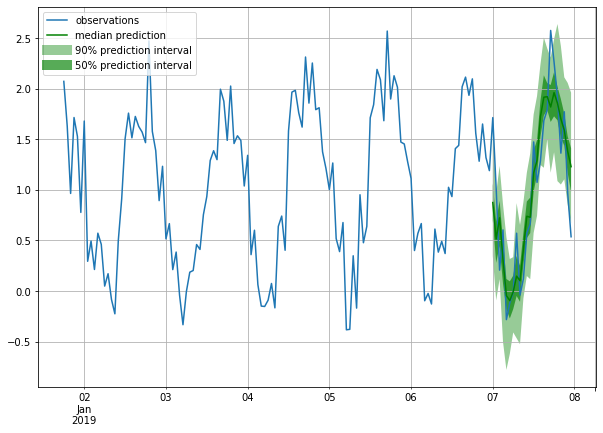

In [52]:
plot_length = 150 
prediction_intervals = (50, 90)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

We can also evaluate the quality of our forecasts. GluonTS comes with an `Evaluator` that returns aggregate error metrics as well as metrics per time series which can be used e.g., for scatter plots.

In [53]:
from gluonts.evaluation import Evaluator

In [54]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 260.60it/s]


In [55]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.10926809072494505,
    "abs_error": 629.7082643508911,
    "abs_target_sum": 2505.765546798706,
    "abs_target_mean": 1.044068977832794,
    "seasonal_error": 0.3378558193842571,
    "MASE": 0.7835231600933785,
    "sMAPE": 0.5341838227286914,
    "MSIS": 7.093171784770663,
    "QuantileLoss[0.1]": 278.2460431121289,
    "Coverage[0.1]": 0.11666666666666665,
    "QuantileLoss[0.5]": 629.7082640072331,
    "Coverage[0.5]": 0.5220833333333332,
    "QuantileLoss[0.9]": 300.75412125289427,
    "Coverage[0.9]": 0.88875,
    "RMSE": 0.3305572427355738,
    "NRMSE": 0.31660479312556683,
    "ND": 0.2513037443408815,
    "wQuantileLoss[0.1]": 0.1110423293462583,
    "wQuantileLoss[0.5]": 0.2513037442037346,
    "wQuantileLoss[0.9]": 0.1200248449569151,
    "mean_wQuantileLoss": 0.1607903061689693,
    "MAE_Coverage": 0.01666666666666662
}


In [56]:
item_metrics.head()

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.125000,0.625000,0.875000,0.901882,0.146861,8.855949,2.786325,7.611340,3.769817,7.611340,1.026606,24.638548,NaN,0.597886,0.351642
1,0.166667,0.708333,0.916667,0.698183,0.110748,6.645781,2.997389,5.701223,2.419105,5.701222,0.924110,22.178631,NaN,0.557277,0.340241
2,0.125000,0.500000,0.750000,0.968245,0.139178,9.347176,2.816423,7.518842,3.498751,7.518842,1.108381,26.601139,NaN,0.673073,0.323560
3,0.250000,0.625000,0.916667,0.867955,0.117798,10.079971,3.313989,6.478961,3.300711,6.478961,0.937597,22.502333,NaN,0.670293,0.311026
4,0.000000,0.500000,0.875000,0.590432,0.065314,6.065535,2.199416,4.437021,3.166279,4.437021,1.077683,25.864388,NaN,0.418185,0.313119


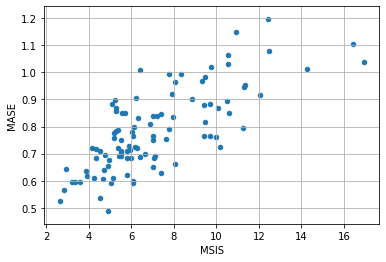

In [57]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# 5. Create your own model

For creating our own forecast model we need to:
- define the training and prediction network
- define a new estimator that specifies any data processing and uses the networks

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:
- Both should have a `hybrid_forward` method that defines what should happen when the network is called    
- The trainng network's `hybrid_forward` should return a **loss** based on the prediction and the true values
- The prediction network's `hybrid_forward` should return the predictions 

The estimator should also follow some rules:
- It should include a `create_transformation` method that defines all the possible feature transformations and how the data is split during training
- It should include a `create_training_network` method that returns the training network configured with any necessary hyperparameters
- It should include a `create_predictor` method that creates the prediction network, and returns a `Predictor` object 

A `Predictor` defines the `predictor.predict` method of a given predictor. This method takes the test dataset, it passes it through the prediction network to take the predictions, and yields the predictions. You can think of the `Predictor` object as a wrapper of the prediction network that defines its `predict` method. 

In this section, we will start simple by creating a feedforward network that is restricted to point forecasts. Then, we will add complexity to the network by expanding it to probabilistic forecasting, considering features and scaling of the time series, and in the end we will replace it with an RNN.

## 5.1 Point forecasts with a simple feedforward network

We can create a simple training network that defines a neural network that takes as input a window of length `context_length` and predicts the subsequent window of dimension `prediction_length` (thus, the output dimension of the network is `prediction_length`). The `hybrid_forward` method of the training network returns the mean of the L1 loss. 

The prediction network is (and should be) identical to the training network (by inheriting the class) and its `hybrid_forward` method returns the predictions.

In [58]:
class MyNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, num_cells, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.num_cells = num_cells
    
        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))


class MyTrainNetwork(MyNetwork):    
    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

The estimator class is configured bys a few hyperparameters and implements the required methods.

In [59]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.trainer import Trainer
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter, FieldName
from mxnet.gluon import HybridBlock

In [60]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        freq: str,
        num_cells: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.num_cells = num_cells
            
    def create_transformation(self):
        # Feature transformation that the model uses for input
        # Here we use a transformation that defines only how the train and test windows are cut
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )
    
    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length,
            num_cells = self.num_cells
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length,
            num_cells=self.num_cells
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

After defining the training and prediction network, as well as the estimator class, we can follow exactly the same steps as with the existing models, i.e., we can specify our estimator by passing all the required hyperparameters to the estimator class, train the estimator by invoking its `train` method to create a predictor, and finally use the `make_evaluation_predictions` function to generate our forecasts.

In [61]:
estimator = MyEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100,),
)

The estimator can be trained using our training dataset `train_ds` just by invoking its `train` method. The training returns a predictor that can be used to predict.

In [62]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Number of parameters in MyTrainNetwork: 104
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 343.44it/s, avg_epoch_loss=0.475]
INFO:root:Epoch[0] Elapsed time 0.293 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.475271
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 355.28it/s, avg_epoch_loss=0.314]
INFO:root:Epoch[1] Elapsed time 0.283 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.313844
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 354.04it/s, avg_epoch_loss=0.3]
INFO:root:Epoch[2] Elapsed time 0.284 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.300249
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 355.16it/s, avg_epoch_loss=0.289]
INFO:root:Epoch[3] Elapsed time 0.283 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.289404
INFO:root:Epoch[4] Learning rate is 0

In [63]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [64]:
forecasts = list(forecast_it)
tss = list(ts_it)

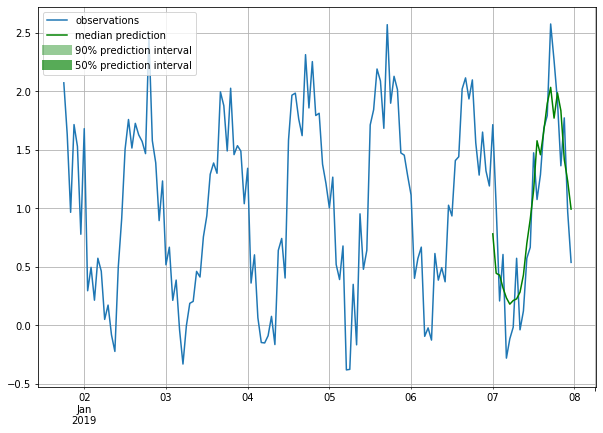

In [65]:
plot_length = 150 
prediction_intervals = (50, 90)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

We observe from the plot above that we cannot actually see any prediction intervals in the predictions. This is expected since the model that we defined does not do probabilistic forecasting but it just gives point estimates. By requiring 100 sample paths (defined in `make_evaluation_predictions`) in such a network, we get 100 times the same output.

## 5.2 Probabilistic forecasting

### 5.2.1 Distributions

Probabilistic forecasting requires that we learn the distribution of the future values of the time series and not the values themselves as in point forecasting. To achieve this, we need to specify the type of distribution that the future values follow. GluonTS comes with a number of different distributions that cover many use cases, such as Gaussian, Student-t and Uniform just to name a few.  


#### How does a model learn a distribution?

In order to learn a distribution we need to learn its parameters. For example, in the simple case where we assume a Gaussian distribution, we need to learn the mean and the variance that fully specify the distribution.

Each distribution that is available in GluonTS is defined by the corresponding `Distribution` class (e.g., `Gaussian`). This class defines -among others- the parameters of the distribution, its (log-)likelihood and a sampling method (given the parameters). 

However, it is not straightforward how to connect a model with such a distribution and learn its parameters. For this, each distribution comes with a `DistributionOutput` class (e.g., `GaussianOutput`). The role of this class is to connect a model with a distribution. Its main usage is to take the output of the model and map it to the parameters of the distribution. You can think of it as an additional projection layer on top of the model. The parameters of this layer are optimized along with the rest of the network.

By including this projection layer, our model effectively learns the parameters of the (chosen) distribution of each time step. Such a model is usually optimized by choosing as a loss function the negative log-likelihood of the chosen distribution. After we optimize our model and learn the parameters we can sample or derive any other useful statistics from the learned distributions.

### 5.2.2 Feedforward network for probabilistic forecasting

Let's see what changes we need to make to the previous model to make it probabilistic: 
- First, we need to change the output of the network. In the point forecast network the output was a vector of length `prediction_length` that gave directly the point estimates. Now, we need to output a set of features that the `DistributionOutput` will use to project to the distribution parameters. These features should be different for each time step at the prediction horizon. Therefore we need an overall output of `prediction_length * num_features` values.
- The `DistributionOutput` takes as input a tensor and uses the last dimension as features to be projected to the distribution parameters. Here, we need a distribution object for each time step, i.e., `prediction_length` distribution objects. Given that the output of the network has `prediction_length * num_features` values, we can reshape it to `(prediction_length, num_features)` and get the required distributions, while the last axis of length `num_features` will be projected to the distribution parameters. 
- We want the prediction network to output many sample paths for each time series. To achieve this we can repeat each time series as many times as the number of sample paths and do a standard forecast for each of them. 

Note that in all the tensors that we handle there is an initial dimension that refers to the batch, e.g., the output of the network has dimension `(batch_size, prediction_length * num_features)`. 

In [66]:
from gluonts.distribution.distribution_output import DistributionOutput
from gluonts.distribution.gaussian import GaussianOutput

In [67]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(self, 
                 prediction_length, 
                 distr_output, 
                 num_cells, 
                 num_sample_paths=100, 
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target):
        # compute network output
        net_output = self.nn(past_target)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        # repeat past target: from (batch_size, past_target_length) to 
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        
        # compute network output
        net_output = self.nn(repeated_past_target)

        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)
       
        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()
        
        # reshape from (batch_size * num_sample_paths, prediction_length) to 
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

The changes we need to do at the estimator are minor and they mainly reflect the additional `distr_output` parameter that our networks use.

In [73]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_sample_paths: int = 100,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths

    def create_transformation(self):
        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            train_sampler=ExpectedNumInstanceSampler(num_instances=1),
            past_length=self.context_length,
            future_length=self.prediction_length,
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [74]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100,),
)

In [75]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Number of parameters in MyProbTrainNetwork: 1002
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 229.91it/s, avg_epoch_loss=0.727]
INFO:root:Epoch[0] Elapsed time 0.436 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.727100
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 249.55it/s, avg_epoch_loss=0.41]
INFO:root:Epoch[1] Elapsed time 0.402 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.410484
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 237.49it/s, avg_epoch_loss=0.363]
INFO:root:Epoch[2] Elapsed time 0.422 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.362644
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 230.87it/s, avg_epoch_loss=0.353]
INFO:root:Epoch[3] Elapsed time 0.434 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.353325
INFO:root:Epoch[4] Learning rat

In [76]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [77]:
forecasts = list(forecast_it)
tss = list(ts_it)

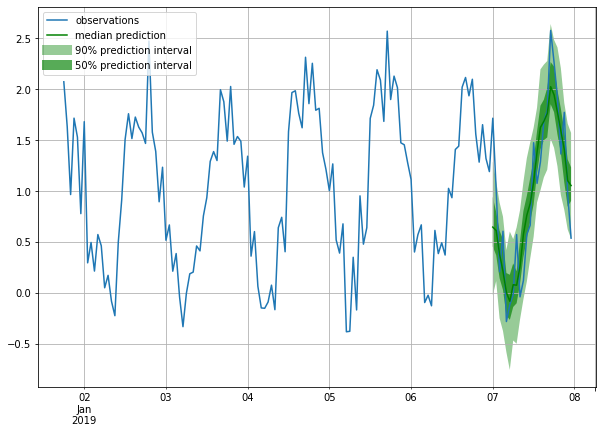

In [78]:
plot_length = 150 
prediction_intervals = (50, 90)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

## 5.3. Add features and scaling

In the previous networks we used only the target and did not leverage any of the features of the dataset. Here we expand the probabilistic network by including the `feat_dynamic_real` field of the dataset that could enhance the forecasting power of our model. We achieve this by concatenating the target and the features to an enhanced vector that forms the new network input. 

All the features that are available in a dataset can be potentionaly used as inputs to our model. However, for the purposes of this example we will restrict ourselves to using only one feature.

An important issue that a practicioner needs to deal with often is the different orders of magnitude in the values of the time series in a dataset. It is extremely helpful for a model to be trained and forecast values that lie roughly in the same value range. To address this issue, we add a `Scaler` to out model, that computes the scale of each time series. Then we can scale accordingly the values of the time series or any related features and use these as inputs to the network.

In [87]:
from gluonts.block.scaler import MeanScaler, NOPScaler

In [88]:
class MyProbNetwork(gluon.HybridBlock):
    def __init__(self, 
                 prediction_length, 
                 context_length, 
                 distr_output, 
                 num_cells, 
                 num_sample_paths=100, 
                 scaling=True, 
                 **kwargs
    ) -> None:
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths = num_sample_paths
        self.proj_distr_args = distr_output.get_args_proj()
        self.scaling = scaling

        with self.name_scope():
            # Set up a 2 layer neural network that its ouput will be projected to the distribution parameters
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=self.num_cells, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length * self.num_cells, activation='relu'))

            if scaling:
                self.scaler = MeanScaler(keepdims=True)
            else:
                self.scaler = NOPScaler(keepdims=True)

    def compute_scale(self, past_target, past_observed_values):
        # scale is computed on the context length last units of the past target
        # scale shape is (batch_size, 1)
        _, scale = self.scaler(
            past_target.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
            past_observed_values.slice_axis(
                axis=1, begin=-self.context_length, end=None
            ),
        )

        return scale


class MyProbTrainNetwork(MyProbNetwork):
    def hybrid_forward(self, F, past_target, future_target, past_observed_values, past_feat_dynamic_real):
        # compute scale 
        scale = self.compute_scale(past_target, past_observed_values)

        # scale target and time features
        past_target_scale = F.broadcast_div(past_target, scale)
        past_feat_dynamic_real_scale = F.broadcast_div(past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(past_target_scale, past_feat_dynamic_real_scale, dim=-1)

        # compute network output
        net_output = self.nn(net_input)

        # (batch, prediction_length * nn_features)  ->  (batch, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)

        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # negative log-likelihood
        loss = distr.loss(future_target)
        return loss


class MyProbPredNetwork(MyProbTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target, past_observed_values, past_feat_dynamic_real):
        # repeat fields: from (batch_size, past_target_length) to
        # (batch_size * num_sample_paths, past_target_length)
        repeated_past_target = past_target.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_observed_values = past_observed_values.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        repeated_past_feat_dynamic_real = past_feat_dynamic_real.repeat(
            repeats=self.num_sample_paths, axis=0
        )
        
        # compute scale
        scale = self.compute_scale(repeated_past_target, repeated_past_observed_values)

        # scale repeated target and time features
        repeated_past_target_scale = F.broadcast_div(repeated_past_target, scale)
        repeated_past_feat_dynamic_real_scale = F.broadcast_div(repeated_past_feat_dynamic_real.squeeze(axis=-1), scale)

        # concatenate target and time features to use them as input to the network
        net_input = F.concat(repeated_past_target_scale, repeated_past_feat_dynamic_real_scale, dim=-1)

        # compute network oputput
        net_output = self.nn(net_input)
        
        # (batch * num_sample_paths, prediction_length * nn_features)  ->  (batch * num_sample_paths, prediction_length, nn_features)
        net_output = net_output.reshape(0, self.prediction_length, -1)

        # project network output to distribution parameters domain
        distr_args = self.proj_distr_args(net_output)
        
        # compute distribution
        distr = self.distr_output.distribution(distr_args, scale=scale)

        # get (batch_size * num_sample_paths, prediction_length) samples
        samples = distr.sample()

        # reshape from (batch_size * num_sample_paths, prediction_length) to
        # (batch_size, num_sample_paths, prediction_length)
        return samples.reshape(shape=(-1, self.num_sample_paths, self.prediction_length))

In [89]:
class MyProbEstimator(GluonEstimator):
    @validated()
    def __init__(
            self,
            prediction_length: int,
            context_length: int,
            freq: str,
            distr_output: DistributionOutput,
            num_cells: int,
            num_sample_paths: int = 100,
            scaling: bool = True,
            trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.freq = freq
        self.distr_output = distr_output
        self.num_cells = num_cells
        self.num_sample_paths= num_sample_paths
        self.scaling = scaling

    def create_transformation(self):
        # Feature transformation that the model uses for input.
        return Chain(
            [
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                    time_series_fields=[
                        FieldName.FEAT_DYNAMIC_REAL,
                        FieldName.OBSERVED_VALUES,
                    ],
                ),

            ]
        )

    def create_training_network(self) -> MyProbTrainNetwork:
        return MyProbTrainNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

    def create_predictor(
            self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyProbPredNetwork(
            prediction_length=self.prediction_length,
            context_length=self.context_length,
            distr_output=self.distr_output,
            num_cells=self.num_cells,
            num_sample_paths=self.num_sample_paths,
            scaling=self.scaling
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

In [90]:
estimator = MyProbEstimator(
    prediction_length=custom_ds_metadata['prediction_length'],
    context_length=2*custom_ds_metadata['prediction_length'],
    freq=custom_ds_metadata['freq'],
    distr_output=GaussianOutput(),
    num_cells=40,
    trainer=Trainer(ctx="cpu", 
                    epochs=5, 
                    learning_rate=1e-3, 
                    hybridize=False, 
                    num_batches_per_epoch=100,),
)

In [91]:
predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Number of parameters in MyProbTrainNetwork: 1002
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 154.81it/s, avg_epoch_loss=0.951]
INFO:root:Epoch[0] Elapsed time 0.648 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.951425
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.79it/s, avg_epoch_loss=0.511]
INFO:root:Epoch[1] Elapsed time 0.601 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=0.511322
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 162.89it/s, avg_epoch_loss=0.456]
INFO:root:Epoch[2] Elapsed time 0.615 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.455928
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 166.21it/s, avg_epoch_loss=0.418]
INFO:root:Epoch[3] Elapsed time 0.603 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.418387
INFO:root:Epoch[4] Learning ra

In [92]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [93]:
forecasts = list(forecast_it)
tss = list(ts_it)

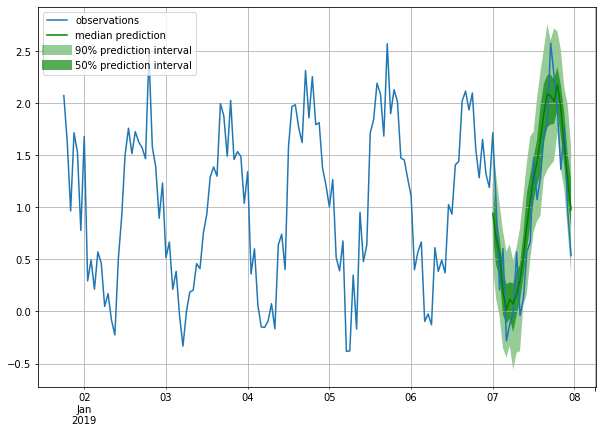

In [94]:
plot_length = 150 
prediction_intervals = (50, 90)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()